In [3]:
import os
import random
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import export_text
from joblib import dump, load
from tqdm import tqdm
from wandb.sklearn import plot_learning_curve
from sklearn.model_selection import GridSearchCV
import time

MODEL_OUTPUT_PATH = "../src/models/"
SCALER_OUTPUT_PATH = "../src/scaler/"

In [4]:
import os
import random
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import export_text
from joblib import dump, load
from tqdm import tqdm
from wandb.sklearn import plot_learning_curve
from sklearn.model_selection import GridSearchCV
import time

MODEL_OUTPUT_PATH = "../src/models/"
SCALER_OUTPUT_PATH = "../src/scaler/"

# Overall Cyber Risk Prediction

## Data Generation

In [5]:
columns = ['Invested Amount', 'Successful Attacks', 'Failed Attacks', 'Business Value', 'Number of Employees', 'Employee Training', 'Known Vulnerabilities', 'External Advisor', 'Risk']
features = columns[:-1]
LEVELS = ['LOW', 'MEDIUM', 'HIGH']
ADVISOR = ['NO', 'YES']
prediction_result_mapping = {0: 'LOW', 1: 'MEDIUM', 2: 'HIGH'}

In [7]:
def generate_data(nr_entries = 1000, min_empl = 30, max_empl = 10000, min_nr_attacks = 0, nr_attacks = 50, 
                  avg_business_value = 5000000, std_business_value = 50000, max_invested_perc = 0.3, max_nr_vulnerabilities = 10):
    df = pd.DataFrame(columns=columns)
    for i in tqdm(range(0, nr_entries)):
        nr_employees = random.randint(min_empl, max_empl)
        employees_training = random.choice(LEVELS)
        
        failed_attack = random.randrange(nr_attacks)
        succ_attack = random.randrange(nr_attacks)
        
        business_value = int(numpy.random.normal(loc=avg_business_value, scale=std_business_value))
        invested_perc = random.uniform(0, max_invested_perc)
        invested_amount = int(invested_perc * business_value)
        
        known_vulnerabilities = random.randrange(max_nr_vulnerabilities)
        external_adv = random.choice(ADVISOR)

        # Risk is computed based on the other parameters and is then categorized using 'get_categorized_risk'
        computed_risk = invested_perc - (succ_attack / nr_attacks) + (nr_employees / max_empl) * LEVELS.index(employees_training) - (known_vulnerabilities / max_nr_vulnerabilities) + ADVISOR.index(external_adv)
                
        df.loc[i] = [invested_amount, succ_attack, failed_attack, business_value, nr_employees, employees_training, known_vulnerabilities, external_adv, get_categorized_risk(computed_risk)]
    return df

def get_categorized_risk(weighted_risk, upper_boundary = 1.0, lower_boundary = 0.0):
  if weighted_risk >= upper_boundary:
      return "LOW"
  elif weighted_risk >= lower_boundary and weighted_risk < upper_boundary:
      return "MEDIUM"
  else:
      return "HIGH"

In [8]:
data = generate_data(nr_entries = 10000)

100%|██████████| 10000/10000 [00:03<00:00, 2903.62it/s]


In [9]:
data.head()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
0,182068,18,21,5080847,7483,HIGH,5,YES,LOW
1,341499,19,33,5014396,7273,HIGH,0,NO,LOW
2,1282511,31,21,4933760,7421,LOW,7,YES,HIGH
3,1314938,45,0,4897289,2953,MEDIUM,5,YES,MEDIUM
4,208202,23,28,5030776,3146,MEDIUM,7,NO,HIGH


In [10]:
data.describe()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Known Vulnerabilities
count,1.000000e+04,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,7.536615e+05,24.649200,24.433500,5.000370e+06,5012.244000,4.499800
std,4.319123e+05,14.468942,14.479231,4.998073e+04,2869.459658,2.870962
min,2.140000e+02,0.000000,0.000000,4.812733e+06,30.000000,0.000000
25%,3.761715e+05,12.000000,12.000000,4.966640e+06,2562.750000,2.000000
50%,7.537355e+05,25.000000,25.000000,5.000384e+06,5038.500000,5.000000
75%,1.129587e+06,37.000000,37.000000,5.034148e+06,7461.500000,7.000000
max,1.529109e+06,49.000000,49.000000,5.177123e+06,9999.000000,9.000000


### Data Export as .csv

In [11]:
data.to_csv('overall_cyber_data.csv')

### Data import

In [12]:
data = pd.read_csv('./overall_cyber_data.csv')
data.pop('Unnamed: 0')

0          0
1          1
2          2
3          3
4          4
        ... 
9995    9995
9996    9996
9997    9997
9998    9998
9999    9999
Name: Unnamed: 0, Length: 10000, dtype: int64

# Data Processing

## Categorization Step

In [13]:
start = time.time()

levels_mapping = { 'LOW': 0, 'MEDIUM': 1, 'HIGH': 2 }
advisor_mapping = { 'NO': 0, 'YES': 1 }

data = data.replace({'Employee Training': levels_mapping, 'Risk': levels_mapping, 'External Advisor': advisor_mapping})

stop = time.time()
print(f"Categorization time: {stop - start}s")

Categorization time: 0.01512598991394043s


In [14]:
data.head()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
0,182068,18,21,5080847,7483,2,5,1,0
1,341499,19,33,5014396,7273,2,0,0,0
2,1282511,31,21,4933760,7421,0,7,1,2
3,1314938,45,0,4897289,2953,1,5,1,1
4,208202,23,28,5030776,3146,1,7,0,2


## Normalization Step - using scaler

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Used for the scikit models
X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["Risk"].values, test_size=0.2)

scaler = MinMaxScaler()
scaler.fit(X_train)

# Normalized Splitted X Data
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [18]:
dump(scaler, SCALER_OUTPUT_PATH + 'MinMaxScaler.joblib') 

['../src/scaler/MinMaxScaler.joblib']

In [19]:
scaler.scale_

array([6.54103518e-07, 2.04081633e-02, 2.04081633e-02, 2.83272477e-06,
       1.00310964e-04, 5.00000000e-01, 1.11111111e-01, 1.00000000e+00])

# Decision Tree Classifier

In [20]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score

In [21]:
dtree = DecisionTreeClassifier()
#dtree = load(MODEL_OUTPUT_PATH + 'Tree_classifier.joblib')

## Parameter Tuning (with K-Fold Cross Validation)

In [22]:
# Define the parameter ranges that should be tested on the model
dtree_params = {
    'criterion': ["gini", "entropy"],
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

# Instanciate the Grid for parameter tuning
dtree_grid = GridSearchCV(dtree, dtree_params, cv=5, scoring='accuracy', n_jobs=-1)

dtree = dtree_grid.fit(X_train, y_train)

In [23]:
pd.DataFrame(dtree.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004773,0.001415,0.000434,0.000054,gini,1,1,2,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.60375,0.615625,0.60125,0.6125,0.616875,0.61,0.006337,1081
1,0.003384,0.000203,0.000732,0.000770,gini,1,1,3,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.60375,0.615625,0.60125,0.6125,0.616875,0.61,0.006337,1081
2,0.005910,0.000400,0.000700,0.000193,gini,1,1,4,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.60375,0.615625,0.60125,0.6125,0.616875,0.61,0.006337,1081
3,0.004237,0.000721,0.000516,0.000203,gini,1,1,5,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.60375,0.615625,0.60125,0.6125,0.616875,0.61,0.006337,1081
4,0.004129,0.000477,0.000596,0.000301,gini,1,1,6,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.60375,0.615625,0.60125,0.6125,0.616875,0.61,0.006337,1081


In [24]:
print(dtree.best_estimator_)
print(dtree.best_params_)
print('Best Accuracy: {0:.2%}'.format(dtree.best_score_))

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=9)
{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 9, 'min_samples_split': 2}
Best Accuracy: 90.49%


## Evaluate

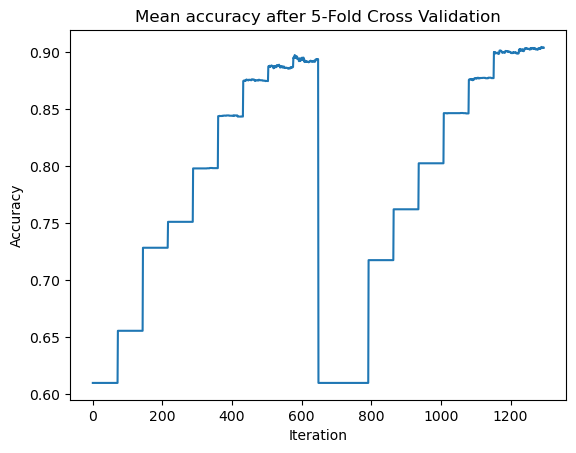

In [25]:
test_scores = dtree.cv_results_['mean_test_score']

plt.title("Mean accuracy after 5-Fold Cross Validation")
plt.plot(test_scores)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [26]:
accuracy = dtree.score(X_test, y_test) 
print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 90.65%


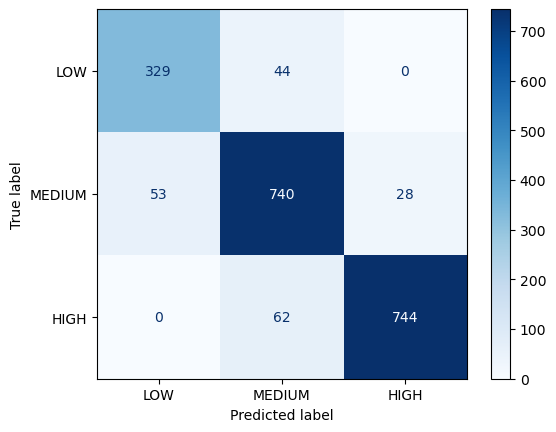

In [27]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, dtree.predict(X_test))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LEVELS)
disp.plot(cmap='Blues')  # Specify the colormap here
plt.show()

In [28]:
print(classification_report(y_test, dtree.predict(X_test), target_names=LEVELS))

              precision    recall  f1-score   support

         LOW       0.86      0.88      0.87       373
      MEDIUM       0.87      0.90      0.89       821
        HIGH       0.96      0.92      0.94       806

    accuracy                           0.91      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.91      0.91      0.91      2000



## Export

In [29]:
#r = export_text(dtree.best_estimator_, feature_names=features)
#print(r)

dump(dtree, MODEL_OUTPUT_PATH + 'Tree_classifier.joblib') 

['../src/models/Tree_classifier.joblib']

## Prediction

In [30]:
# Create DataFrame from data to be predicted
prediction_df = pd.DataFrame([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]], columns=features)
prediction_df

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor
0,1077113,8,29,4947796,57879,1,6,0


In [31]:
predicted_risk = dtree.predict(prediction_df)[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: MEDIUM


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


# Support Vector Machine (SVM) classifier

In [32]:
from sklearn.svm import LinearSVC, SVC 

## Parameter Tuning (with K-Fold Cross Validation)

In [33]:
svm = SVC()
#svm = load(MODEL_OUTPUT_PATH + 'SVM_classifier.joblib') 

In [34]:
# Define the parameter ranges that should be tested on the model
svm_params = {
    'kernel': ["poly", "rbf", "sigmoid"],
    'gamma': ["scale", "auto"]
}

# Instanciate the Grid for parameter tuning
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', n_jobs=-1)

svm = svm_grid.fit(X_train_normalized, y_train)

In [35]:
pd.DataFrame(svm.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.128190,0.004311,0.015576,0.002078,scale,poly,"{'gamma': 'scale', 'kernel': 'poly'}",0.97375,0.976875,0.978125,0.971875,0.975000,0.975125,0.002215,1
1,0.225414,0.028369,0.127658,0.009005,scale,rbf,"{'gamma': 'scale', 'kernel': 'rbf'}",0.97000,0.970625,0.965625,0.961875,0.969375,0.967500,0.003307,2
2,0.768574,0.096777,0.192352,0.023219,scale,sigmoid,"{'gamma': 'scale', 'kernel': 'sigmoid'}",0.43000,0.435625,0.435625,0.451875,0.308125,0.412250,0.052574,6
3,0.403131,0.031211,0.103457,0.007846,auto,poly,"{'gamma': 'auto', 'kernel': 'poly'}",0.90125,0.907500,0.905000,0.896875,0.900000,0.902125,0.003742,4
4,0.300085,0.015001,0.179108,0.035388,auto,rbf,"{'gamma': 'auto', 'kernel': 'rbf'}",0.94625,0.935000,0.942500,0.932500,0.933750,0.938000,0.005397,3


In [36]:
print(svm.best_estimator_)
print(svm.best_params_)
print('Best Accuracy: {0:.2%}'.format(svm.best_score_))

SVC(kernel='poly')
{'gamma': 'scale', 'kernel': 'poly'}
Best Accuracy: 97.51%


## Evaluate

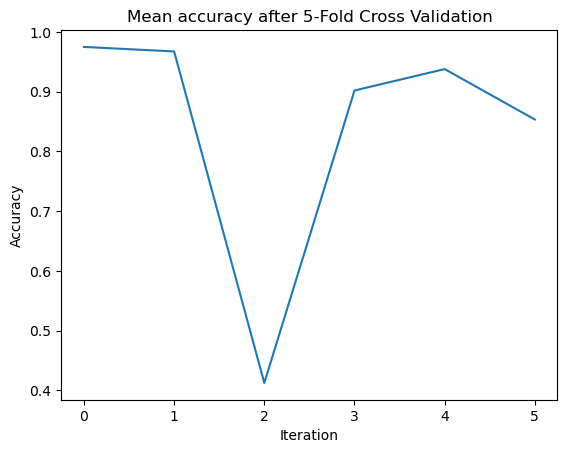

In [37]:
test_scores = svm.cv_results_['mean_test_score']

plt.title("Mean accuracy after 5-Fold Cross Validation")
plt.plot(test_scores)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [38]:
accuracy = svm.score(X_test_normalized, y_test) 

print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 97.75%


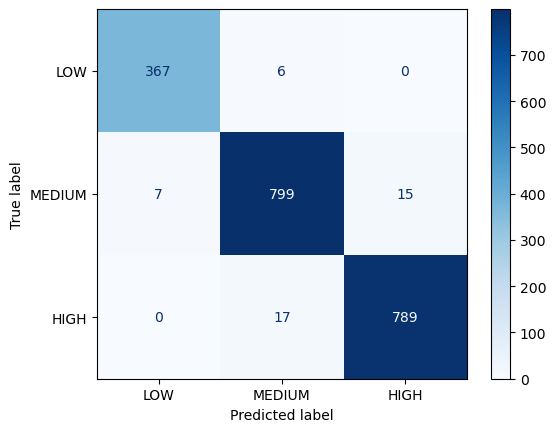

In [39]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, svm.predict(X_test_normalized))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LEVELS)
disp.plot(cmap='Blues')  # Specify the colormap here
plt.show()

In [40]:
print(classification_report(y_test, svm.predict(X_test_normalized), target_names=LEVELS))

              precision    recall  f1-score   support

         LOW       0.98      0.98      0.98       373
      MEDIUM       0.97      0.97      0.97       821
        HIGH       0.98      0.98      0.98       806

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



## Export

In [41]:
dump(svm, MODEL_OUTPUT_PATH + 'SVM_classifier.joblib') 

['../src/models/SVM_classifier.joblib']

## Prediction

In [42]:
predicted_risk = svm.predict(scaler.transform([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]]))[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: LOW


# K-nearest Neighbours Classifier

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
knn = KNeighborsClassifier()
#knn = load(MODEL_OUTPUT_PATH + 'KNN_classifier.joblib') 

## Parameter Tuning (with K-Fold Cross Validation)

In [45]:
# Define the parameter ranges that should be tested on the model
knn_params = {
    'n_neighbors': range(1, 30),
    'weights': ['uniform', 'distance']
}

# Instanciate the Grid for parameter tuning
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy', n_jobs=-1)

knn = knn_grid.fit(X_train_normalized, y_train)

In [46]:
pd.DataFrame(knn.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002809,0.000282,0.038984,0.004476,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.89875,0.912500,0.896250,0.891250,0.888750,0.897500,0.008292,55
1,0.003901,0.002053,0.014386,0.002782,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.89875,0.912500,0.896250,0.891250,0.888750,0.897500,0.008292,55
2,0.002323,0.000551,0.041926,0.005288,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.88625,0.892500,0.886875,0.895000,0.880000,0.888125,0.005244,58
3,0.003235,0.000559,0.017883,0.001498,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.89875,0.912500,0.896250,0.891250,0.888750,0.897500,0.008292,55
4,0.002543,0.000657,0.045973,0.007957,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.92000,0.931875,0.913750,0.911875,0.910625,0.917625,0.007820,53


In [47]:
print(knn.best_estimator_)
print(knn.best_params_)
print('Best Accuracy: {0:.2%}'.format(knn.best_score_))

KNeighborsClassifier(n_neighbors=15, weights='distance')
{'n_neighbors': 15, 'weights': 'distance'}
Best Accuracy: 93.16%


## Evaluate

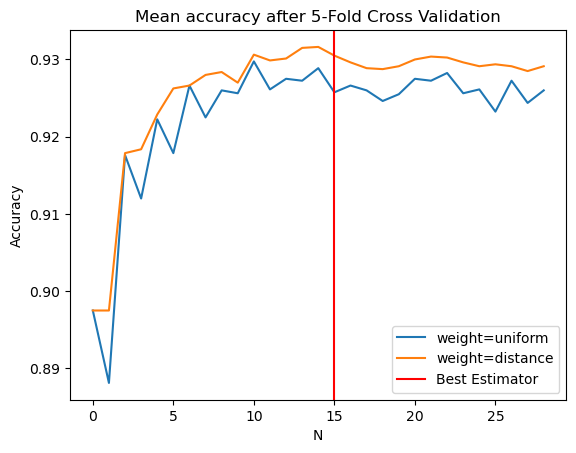

In [48]:
test_scores_weight_uniform = [ x for ind, x in enumerate(knn.cv_results_['mean_test_score']) if ind % 2 == 0]
test_scores_weight_distance = [ x for ind, x in enumerate(knn.cv_results_['mean_test_score']) if ind % 2 == 1]


plt.title("Mean accuracy after 5-Fold Cross Validation")
plt.plot(test_scores_weight_uniform, label='weight=uniform')
plt.plot(test_scores_weight_distance, label='weight=distance')
plt.axvline(x=knn.best_params_['n_neighbors'], label='Best Estimator', color='r')
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [49]:
accuracy = knn.score(X_test_normalized, y_test) 
print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 93.45%


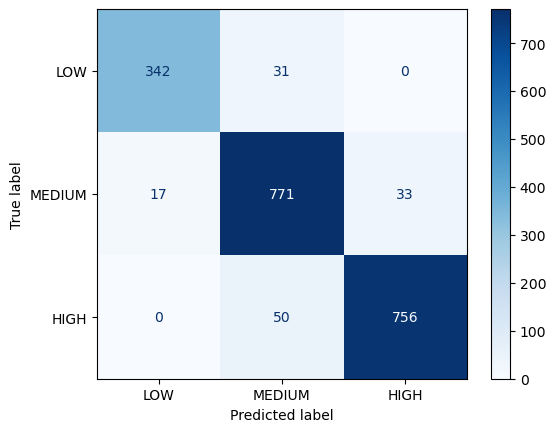

In [50]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, knn.predict(X_test_normalized))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LEVELS)
disp.plot(cmap='Blues')  # Specify the colormap here
plt.show()


In [51]:
print(classification_report(y_test, knn.predict(X_test_normalized), target_names=LEVELS))

              precision    recall  f1-score   support

         LOW       0.95      0.92      0.93       373
      MEDIUM       0.90      0.94      0.92       821
        HIGH       0.96      0.94      0.95       806

    accuracy                           0.93      2000
   macro avg       0.94      0.93      0.93      2000
weighted avg       0.94      0.93      0.93      2000



## Export

In [52]:
dump(knn, MODEL_OUTPUT_PATH + 'KNN_classifier.joblib') 

['../src/models/KNN_classifier.joblib']

## Prediction

In [53]:
predicted_risk = knn.predict(scaler.transform([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]]))[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: MEDIUM


# Multilayer Perceptron (MLP) using Backpropagation

In [54]:
from sklearn.neural_network import MLPClassifier

In [55]:
mlp = MLPClassifier()
#mlp = load(MODEL_OUTPUT_PATH + 'MLP_classifier.joblib') 

## Parameter Tuning (with K-Fold Cross Validation)

In [56]:
mlp_params={
'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(5, 5)],
'solver': ["lbfgs", "sgd", "adam"],
'activation': ["logistic", "relu", "tanh"]
}

# Instanciate the Grid for parameter tuning
mlp_grid = GridSearchCV(mlp, mlp_params, cv=5, scoring='accuracy', n_jobs=-1)

mlp = mlp_grid.fit(X_train_normalized, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

In [57]:
mlp_result = pd.DataFrame(mlp.cv_results_)

mlp_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.467336,0.023371,0.000528,0.000008,logistic,"(5, 5)",constant,lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",0.940625,0.953750,0.991875,0.975625,0.933750,0.959125,0.021725,8
1,0.135200,0.010219,0.001034,0.000274,logistic,"(5, 5)",constant,sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",0.416875,0.416250,0.416250,0.416250,0.429375,0.419000,0.005193,24
2,1.360755,0.062291,0.000522,0.000014,logistic,"(5, 5)",constant,adam,"{'activation': 'logistic', 'hidden_layer_sizes...",0.911250,0.895000,0.892500,0.892500,0.888750,0.896000,0.007882,17
3,0.505164,0.045571,0.000581,0.000129,logistic,"(5, 5)",invscaling,lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",0.969375,0.987500,0.938125,0.911875,0.896875,0.940750,0.033972,13
4,0.244894,0.234780,0.000487,0.000006,logistic,"(5, 5)",invscaling,sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",0.403125,0.180625,0.416250,0.403125,0.180625,0.316750,0.111249,27


In [58]:
print(mlp.best_estimator_)
print(mlp.best_params_)
print('Best Accuracy: {0:.2%}'.format(mlp.best_score_))

MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 5), solver='lbfgs')
{'activation': 'tanh', 'hidden_layer_sizes': (5, 5), 'learning_rate': 'constant', 'solver': 'lbfgs'}
Best Accuracy: 98.94%


## Evaluate

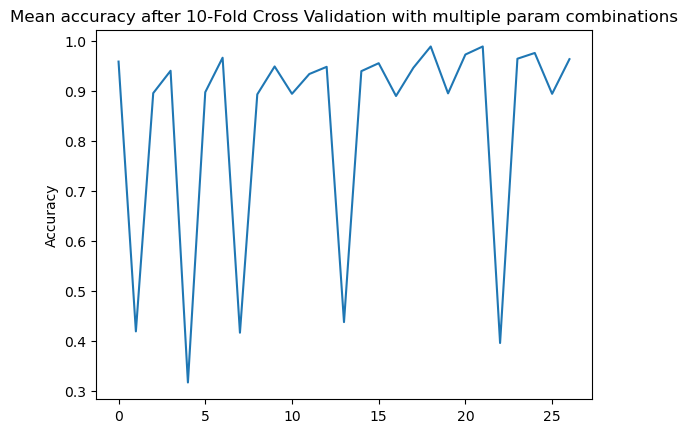

In [59]:
test_scores = mlp.cv_results_['mean_test_score']

plt.title("Mean accuracy after 10-Fold Cross Validation with multiple param combinations")
plt.plot(test_scores)
plt.ylabel("Accuracy")
plt.show()

In [60]:
accuracy = mlp.score(X_test_normalized, y_test) 
print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 99.05%


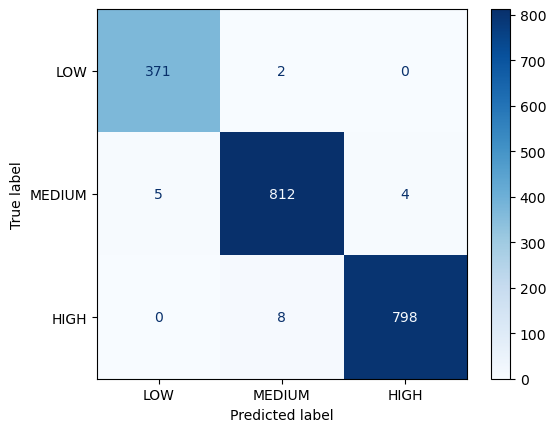

In [61]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, mlp.predict(X_test_normalized))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LEVELS)
disp.plot(cmap='Blues')  # Specify the colormap here
plt.show()


In [62]:
print(classification_report(y_test, mlp.predict(X_test_normalized), target_names=LEVELS))

              precision    recall  f1-score   support

         LOW       0.99      0.99      0.99       373
      MEDIUM       0.99      0.99      0.99       821
        HIGH       1.00      0.99      0.99       806

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



## Export

In [63]:
dump(mlp, MODEL_OUTPUT_PATH + 'MLP_classifier.joblib') 

['../src/models/MLP_classifier.joblib']

## Prediction

In [64]:
predicted_risk = mlp.predict(scaler.transform([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]]))[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: LOW
